In [1]:
import sys
import mne
import scipy.io as sp
from scipy import interpolate
import numpy as np
import random
import pandas as pd
import multiprocessing as mp
import concurrent.futures
from mne.decoding import CSP
import pymrmr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging
from scipy.io import loadmat
from scipy.signal import hamming
from scipy.signal import hann
from scipy.signal import blackman
from scipy.signal import kaiser
from scipy.signal import gaussian
from sklearn.decomposition import FastICA
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
# import lightgbm as lgb
# from catboost import CatBoostClassifier
# from sklearn.impute import KNNImputer
# from sklearn.decomposition import PCA
# from pyriemann.estimation import Covariances
# from pyriemann.tangentspace import TangentSpace
# from pyriemann.classification import MDM
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import os
import pickle
import multiprocessing
from sklearn.model_selection import GridSearchCV



/home/mahdi146/jupyter2/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Set display options for NumPy
np.set_printoptions(threshold=np.inf)

# Initialization

In [3]:
WINDOW_TIME_LENGTH = 4
SAMPLING_RATE = 250
NUMBER_OF_CHANNELS = 64
beta = 1.5

epoch_length = 1000
sampling_freq = 250
number_of_runs = 10
number_of_components = 10
number_of_selected_features = 10
number_of_processes = 10
number_of_bands = 9
column_names = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block']
column_names_v2 = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block','test_acc_vote']


trial_order=[['Tongue','Feet','Mis','Hand'],
            ['Feet','Mis','Hand','Tongue'],
            ['Hand','Feet','Tongue','Mis'],
            ['Tongue','Mis','Hand','Feet'],
            ['Mis','Feet','Hand','Tongue'],
            ['Feet','Hand','Tongue','Mis'],
            ['Hand','Tongue','Mis','Feet'],
            ['Tongue','Feet','Mis','Hand'],
            ['Mis','Tongue','Hand','Feet']]


# Functions

In [4]:
def get_task_rest_times(b_num):
    if b_num == 0:
        task_time = [[12, 16, 20, 8],
                    [16, 12, 20, 8],
                    [20, 16, 8, 12],
                    [20, 12, 8, 16]]
        
        rest_time = [[20, 8, 16, 12],
                    [16, 20, 8, 12],
                    [12, 20, 16, 8],
                    [20, 12, 8, 16]]
        
    elif b_num == 1:
        task_time = [[12, 8, 20, 16],
                    [16, 20, 8, 12],
                    [8, 20, 16, 12],
                    [8, 12, 20, 16]]
        
        rest_time = [[16, 12, 8, 20],
                    [8, 20, 12, 16],
                    [20, 16, 8, 12],
                    [12, 16, 20, 8]]
        
    elif b_num == 2:
        task_time = [[16, 8, 12, 20],
                    [20, 16, 12, 8],
                    [12, 20, 8, 16],
                    [8, 12, 16, 20]]
        
        rest_time = [[8, 20, 16, 12],
                    [12, 8, 20, 16],
                    [16, 12, 20, 8],
                    [8, 12, 20, 16]]
        
    elif b_num == 3:
        task_time = [[12, 16, 20, 8],
                    [16, 12, 20, 8],
                    [20, 16, 8, 12],
                    [20, 12, 8, 16]]
        
        rest_time = [[20, 8, 16, 12],
                    [16, 20, 8, 12],
                    [12, 20, 16, 8],
                    [20, 12, 8, 16]]
        
    elif b_num == 4:
        task_time = [[16, 8, 20, 12],
                    [12, 16, 8, 20],
                    [20, 8, 12, 16],
                    [8, 20, 12, 16]]
        
        rest_time = [[8, 12, 16, 20],
                    [16, 20, 12, 8],
                    [12, 16, 8, 20],
                    [20, 8, 12, 16]]
        
    elif b_num == 5:
        task_time = [[16, 12, 8, 20],
                    [20, 16, 12, 8],
                    [8, 16, 20, 12],
                    [12, 8, 16, 20]]

        rest_time = [[12, 8, 16, 20],
                    [16, 8, 20, 12],
                    [20, 12, 16, 8],
                    [8, 16, 12, 20]]
        
    elif b_num == 6:
        task_time = [[16, 8, 12, 20],
                    [20, 8, 16, 12],
                    [8, 16, 12, 20],
                    [16, 20, 12, 8]]

        rest_time = [[16, 8, 12, 20],
                    [12, 20, 8, 16],
                    [20, 16, 12, 8],
                    [8, 16, 20, 12]]     
    elif b_num ==7:
        task_time = [[12, 8, 20, 16],
                    [16, 20, 8, 12],
                    [8, 20, 16, 12],
                    [8, 12, 20, 16]]   
               
        rest_time = [[16, 12, 8, 20],
                    [8, 20, 12, 16],
                    [20, 16, 8, 12],
                    [12, 16, 20, 8]]  
    
    elif b_num == 8:
        task_time = [[16, 8, 12, 20],
                    [20, 16, 12, 8],
                    [12, 20, 8, 16],
                    [8, 12, 16, 20]]
        
        rest_time = [[8, 20, 16, 12],
                    [12, 8, 20, 16],
                    [16, 12, 20, 8],
                    [8, 12, 20, 16]]
        
    else:
        raise("Error in block number")
    

    return task_time,rest_time


In [5]:
def trial_times_genertor(task_times,rest_times):
    block_times = [item for pair in zip(task_times, rest_times) for item in pair]
    return block_times
    

In [6]:

def fill_zeros_with_average(matrix):
    # Iterate through the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for k in range(matrix.shape[2]):
                if matrix[i, j, k] == 0:
                    # Find the neighboring non-zero elements
                    neighbors = []
                    if i > 0 and matrix[i - 1, j, k] != 0:
                        neighbors.append(matrix[i - 1, j, k])
                    if i < matrix.shape[0] - 1 and matrix[i + 1, j, k] != 0:
                        neighbors.append(matrix[i + 1, j, k])
                    if j > 0 and matrix[i, j - 1, k] != 0:
                        neighbors.append(matrix[i, j - 1, k])
                    if j < matrix.shape[1] - 1 and matrix[i, j + 1, k] != 0:
                        neighbors.append(matrix[i, j + 1, k])
                    if k > 0 and matrix[i, j, k - 1] != 0:
                        neighbors.append(matrix[i, j, k - 1])
                    if k < matrix.shape[2] - 1 and matrix[i, j, k + 1] != 0:
                        neighbors.append(matrix[i, j, k + 1])

                    # Fill the zero with the average of neighboring non-zero values
                    if neighbors:
                        matrix[i, j, k] = sum(neighbors) / len(neighbors)

    return matrix

In [7]:
def calc_csp(x_train, y_train, x_test,number_of_components):
    # csp = CSP(n_components=number_of_components, reg='ledoit_wolf', log=True)
    csp = CSP(number_of_components)



    
    # x_train = fill_zeros_with_average(x_train)
    # x_train = np.add(x_train, 0.000001)



    # nan_count = np.isnan(x_train).sum()
    # print("Number of NaN values:", nan_count)

    # empty_field_count = np.count_nonzero(x_train == 0)
    # print("Number of empty fields:", empty_field_count)

    # zeros_locations_3d = np.where(x_train == 0)
    # print("Locations of zeros:", zeros_locations)
    
# Printing indices and corresponding values
    # for depth_idx, row_idx, col_idx in zip(zeros_locations_3d[0], zeros_locations_3d[1], zeros_locations_3d[2]):
    #     value_at_zero_location = x_train[depth_idx, row_idx, col_idx]
    #     print(f"Zero found at position ({depth_idx}, {row_idx}, {col_idx}) with value {value_at_zero_location}")


    csp_fit = csp.fit(x_train, y_train)
    train_feat = csp_fit.transform(x_train)
    test_feat = csp_fit.transform(x_test)
    return train_feat, test_feat

In [8]:
def class_extractor(number_of_epochs, class_1, class_2, data, labels):
    size = sum(labels[:,0] == class_1) + sum(labels[:,0] == class_2)
    Final_labels = np.zeros((size,1)).astype(int)
    dataset = np.zeros((size,num_channels, epoch_length))
    index = 0
    for i in range(number_of_epochs):
        if labels[i,0] == class_1 or labels[i,0] == class_2:
            dataset[index,:,:] = data[i,:,:]
            Final_labels[index,0] = labels[i,0]
            index = index + 1
        else:
            continue
            
    return dataset, Final_labels

In [9]:
def feature_extractor(dataset, labels, number_of_bands, test_data,number_of_components):

    low_cutoff = 0
    
    for b in range(number_of_bands):
        logging.getLogger('mne').setLevel(logging.WARNING)
        low_cutoff += 4
        data = dataset.copy()
        data_test = test_data.copy() 
        print("Frequency range: ",low_cutoff)
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        filtered_data_test = mne.filter.filter_data(test_data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)

        #PCA
        # from mne.decoding import UnsupervisedSpatialFilter
        # from sklearn.decomposition import PCA, FastICA

        # pca = UnsupervisedSpatialFilter(PCA(64), average=False)
        # pca_fit = pca.fit(filtered_data)
        # filtered_data = pca_fit.transform(filtered_data)
        # filtered_data_test = pca_fit.transform(filtered_data_test)
        # train_feats = filtered_data
        # test_feats = filtered_data_test

        # filtered_data = data
        # filtered_data_test = data_test
        
        [train_feats, test_feats] = calc_csp(filtered_data, labels[:,0], filtered_data_test,number_of_components)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
    
    return train_features, test_features

In [10]:
def feature_selector(train_features, labels, number_of_selected_features):
    X = pd.DataFrame(train_features)
    y = pd.DataFrame(labels)
    K = number_of_selected_features
    
    df = pd.concat([y,X], axis = 1)
    df.columns = df.columns.astype(str)
        
    selected_features = list(map(int, pymrmr.mRMR(df, 'MID', K)))
    return selected_features

In [11]:
def data_reader(path,p_num,block_list):
    data_dict = {}
    for b_num in block_list:
        print(b_num)
        mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
        df = pd.DataFrame(mat['Data'])
        data_dict[b_num] = df
    return data_dict


In [12]:
def get_group_start_indices(dataframe):
    group_indices = []
    current_label = None

    for idx, row in dataframe.iterrows():
        if row.iloc[-1] != current_label:
            group_indices.append(idx)
            current_label = row.iloc[-1]

    return group_indices

In [13]:
def extra_samples_counter(df,class_1,class_2):
    x=0
    i=0
    sampleList = []
    while i<len(df):
        if (df.iloc[i,-1]==class_1):
            x+=1
        else:
            i-=1
            sampleList.append(x)
            x=0
            class_1,class_2 = class_2,class_1
        i+=1
    sampleList.append(x)
    print(sampleList)
    

In [14]:
def extra_samples_block_counter(df,trial_order,b_num):

    df.drop(df[df.iloc[:,-1].isin(['Begin', 'End'])].index, inplace=True)
    df.reset_index(drop=True, inplace=True)    
    df['group'] = (df.iloc[:,-1] != df.iloc[:,-1].shift(1)).cumsum()

    
    group_counts_Rest = df[df.iloc[:,-1] == 'Rest'].groupby('group').size()
    with open('sampleList.txt', 'a') as file:
        file.write(f'block {b_num+1} '+'\n')
        for j in range (len(trial_order)):
            print(trial_order[j])
            trial_num = j
            task_times,rest_times = get_task_rest_times(b_num)
            trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
            trial_samples = [item*SAMPLING_RATE for item in trial_times]
            group_counts_task = df[df.iloc[:,-1] == trial_order[j]].groupby('group').size()
            sampleList = []
            for i in range(4):
                task = group_counts_task.iloc[i]
                rest = group_counts_Rest.iloc[4*j+i]
                sampleList.append(task)
                sampleList.append(rest)
            # extra_samples = [x-y for x,y in zip(sampleList,trial_samples)]
            file.write(', '.join(map(str, sampleList)) + f' trial={trial_order[j]} '+'\n')
            print(sampleList)
        file.write('\n\n')


In [15]:
def data_cleaner(df,class_1,class_2,tasks_time):
    # sys.exit() 
    class_x = class_1
    class_y = class_2
    new_df = pd.DataFrame()
    trial_df = df.copy() 
    # print(tasks_time)
    for i in range(len(tasks_time)):
        sample_point = tasks_time[i]*SAMPLING_RATE
        if(trial_df.iloc[sample_point+1,-1] == class_x ):
            if(i==len(tasks_time)-1):
                temp_df = trial_df.iloc[:sample_point,:]
                new_df = pd.concat([new_df, temp_df], axis=0)
                new_df.reset_index(drop=True, inplace=True)
            else:    
                temp_df = trial_df.iloc[:sample_point,:]
                next_task_idx = trial_df[trial_df.iloc[:, -1] == class_y].index
                trial_df.drop(trial_df.index[0:next_task_idx[0]], inplace=True)
                trial_df.reset_index(drop=True, inplace=True)
                new_df = pd.concat([new_df, temp_df], axis=0)
                new_df.reset_index(drop=True, inplace=True)
                class_x,class_y = class_y,class_x

    return new_df

In [16]:
def class_seperator(cleaned_df,class_1,class_2):
    df = cleaned_df
    sorting_order = {class_1: 0, class_2: 1}

    df['sorting_order'] = df.iloc[:, -1].map(sorting_order)
    df.sort_values(by=['sorting_order', df.columns[-1]], inplace=True)
    df.drop('sorting_order', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [17]:
def shuffler(dataset,labels):
    print(dataset.shape)
    print(labels.shape)
    np.random.seed(42)
    indices = np.random.permutation(len(dataset))
    shuffled_dataset = dataset[indices]
    shuffled_labels = labels[indices]
    return shuffled_dataset,shuffled_labels
    

In [18]:
def cal_epoch(df_len,sliding_len,window_len):
    # print(window_len,sliding_len,df_len)
    number_of_epochs = int((int(df_len-window_len)/sliding_len)) +1
    return number_of_epochs

In [19]:
def data_label_attacher(cleaned_df,class_1,class_2,random_flag,class_seperator_flag,sliding_time,window_time_length,window_type,number_of_channels):
    SLIDING_POINTS = int(sliding_time*SAMPLING_RATE)
    window_time = window_time_length
    WINDOW_SAMPLE_LENGTH = window_time*SAMPLING_RATE
    new_df_ = cleaned_df.copy()
    new_df_.drop(cleaned_df.columns[-1], axis=1, inplace=True)
    X = new_df_.to_numpy()
    X = np.transpose(X)
    number_of_epochs = cal_epoch(int(int(len(cleaned_df)/SAMPLING_RATE)),sliding_time,window_time)
    # print(number_of_epochs)
    dataset = np.zeros((number_of_epochs,number_of_channels,WINDOW_SAMPLE_LENGTH))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    index = get_group_start_indices(cleaned_df)
    index.append(len(cleaned_df))
    k = 0  
    startIdx = int(k * WINDOW_SAMPLE_LENGTH)
    endIdx = int((k+1) * WINDOW_SAMPLE_LENGTH )
    l = 0
    label = 1
    for i in range(number_of_epochs):
        
        if(startIdx>=index[l] and endIdx<=index[l+1]):
            # print(startIdx,endIdx,index[l],index[l+1],"start, end, index[l], index[l+1] in if")
            slice_X = X[:, startIdx:endIdx]

            if window_type == "Kaiser":
                kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,beta)
                slice_X *= kaiser_window

            elif window_type == "Hamming":
                hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
                slice_X *= hamming_window
            
            elif window_type == "Hanning":
                hanning_window = hann(WINDOW_SAMPLE_LENGTH)
                slice_X *= hanning_window
            
            elif window_type == "Rec":
                pass

            else:
                raise ValueError("Window type is wrong!")

            dataset[i, :, :] = slice_X
            labels[i,0] = label
            # print("i is: ",i)
            # print("label is: ",label)

        else:
            
            temp = endIdx-index[l+1]
            # print(temp,endIdx,index[l+1],"temp,end,index l+1")
            slice_X = X[:, startIdx:endIdx]
            if window_type == "Kaiser":
                kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,beta)
                slice_X *= kaiser_window

            elif window_type == "Hamming":
                hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
                slice_X *= hamming_window
            
            elif window_type == "Hanning":
                hanning_window = hann(WINDOW_SAMPLE_LENGTH)
                slice_X *= hanning_window
            
            elif window_type == "Rec":
                pass
            
            else:
                raise ValueError("Window type is wrong!")
            dataset[i, :, :] = slice_X

            if(temp<WINDOW_SAMPLE_LENGTH/2):
                # print("i is: ",i)
                # print("label is: ",label)
                labels[i,0] = label
            else:
                labels[i,0] = int(not(label))
                # print("i is: ",i)
                # print("label is: ",int(not(label)))

            if(startIdx>=index[l+1]):
                l+=1
                # print(f"label changed in i = {i}")
                label = int(not(label))

                

            

        startIdx+=SLIDING_POINTS
        endIdx+=SLIDING_POINTS
    








        # a = df_len - wdinow_len
        # a/sliding_len
        # b = a%sliding_len





####################################################


    # new_df_ = cleaned_df.copy()
    # new_df_.drop(cleaned_df.columns[-1], axis=1, inplace=True)
    # X = new_df_.to_numpy()
    # X = np.transpose(X)
    # number_of_epochs = int(len(new_df_)/WINDOW_SAMPLE_LENGTH)
    # number_of_epochs = int((int(len(new_df_))-WINDOW_SAMPLE_LENGTH)/SLIDING_POINTS) +1

    
    # dataset = np.zeros((number_of_epochs,NUMBER_OF_CHANNELS,WINDOW_SAMPLE_LENGTH))
    # labels = np.zeros((number_of_epochs,1)).astype(int)
















    
    # #Initialization
    # if class_seperator_flag:
    #     seperated_class_df = class_seperator(cleaned_df,class_1,class_2)
    #     new_df_ = seperated_class_df.copy()
    #     new_df_.drop(seperated_class_df.columns[-1], axis=1, inplace=True)
    #     X = new_df_.to_numpy()
    #     X = np.transpose(X)
    #     empty_field_count = np.count_nonzero(X == 0)
    #     print("Number of empty fields in X:", empty_field_count)
    #     # zero_indices = np.where(X == 0)
    #     # print("befor filling",len(zero_indices[0]))
    #     # X[zero_indices] += 0.001
    #     # zero_indices = np.where(X == 0)
    #     # print("after filling",len(zero_indices[0]))
    #     number_of_epochs = int((int(len(new_df_))-WINDOW_SAMPLE_LENGTH)/TR_SLIDING_POINTS)
    #     print(number_of_epochs)
    # else :  
    #     new_df_ = cleaned_df.copy()
    #     new_df_.drop(cleaned_df.columns[-1], axis=1, inplace=True)
    #     X = new_df_.to_numpy()
    #     X = np.transpose(X)
    #     empty_field_count = np.count_nonzero(X == 0)
    #     print("Number of empty fields in X:", empty_field_count)
    #     # zero_indices = np.where(X == 0)
    #     # print("befor filling",len(zero_indices[0]))
    #     # X[zero_indices] += 0.001
    #     # zero_indices = np.where(X == 0)
    #     # print("after filling",len(zero_indices[0]))

    #     number_of_epochs = int(len(new_df_)/WINDOW_SAMPLE_LENGTH)

    # dataset = np.zeros((number_of_epochs,NUMBER_OF_CHANNELS,WINDOW_SAMPLE_LENGTH))
    # labels = np.zeros((number_of_epochs,1)).astype(int)

    # if class_seperator_flag:
    #     i = 0  
    #     startIdx = i * WINDOW_SAMPLE_LENGTH
    #     endIdx = (i+1) * WINDOW_SAMPLE_LENGTH 
    #     while(endIdx<=int(len(new_df_))/2):
    #         slice_X = X[:, startIdx:endIdx]

    #         kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,beta)
    #         slice_X *= kaiser_window

    #         dataset[i, :, :] = slice_X
    #         labels[i,0] = 0
    #         # if (seperated_class_df.iloc[startIdx, 64] == class_1):
    #         #     labels[i,0] = 0
    #         # elif(seperated_class_df.iloc[startIdx, 64] == class_2):
    #         #     labels[i,0] = 1
    #         # else:
    #         #     labels[i,0] = 2
    #         startIdx+=TR_SLIDING_POINTS
    #         endIdx+=TR_SLIDING_POINTS
    #         i+=1
    #     # print(int(len(new_df_))/2,"len")    
    #     # print(endIdx,"endIdx")    
    #     # print(seperated_class_df.iloc[endIdx-2:endIdx+2,64])
       
    #     j = i
        
    #     startIdx = endIdx-TR_SLIDING_POINTS
    #     endIdx = startIdx+WINDOW_SAMPLE_LENGTH
    #     print(j, "j is this")
    #     while(endIdx<=int(len(new_df_))):
    #         slice_X = X[:, startIdx:endIdx]

    #         kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,beta)
    #         slice_X *= kaiser_window

    #         dataset[j, :, :] = slice_X
    #         labels[j,0] = 1
    #         # if (cleaned_df.iloc[startIdx, 64] == class_1):
    #         #     labels[j,0] = 0
    #         # elif(cleaned_df.iloc[startIdx, 64] == class_2):
    #         #     labels[j,0] = 1
    #         # else:
    #         #     labels[j,0] = 2
    #         startIdx+=TR_SLIDING_POINTS
    #         endIdx+=TR_SLIDING_POINTS
    #         j+=1
    #     print(j, "j is this")
    #     # dataset,labels = shuffler(dataset,labels)

    # else:
    #     i = 0  
    #     start_idx = i * WINDOW_SAMPLE_LENGTH
    #     end_idx = (i+1) * WINDOW_SAMPLE_LENGTH 
    #     while (end_idx<=int(len(new_df_))):
    #         slice_X = X[:, start_idx:end_idx]

    #         kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,beta)
    #         slice_X *= kaiser_window
            
    #         dataset[i, :, :] = slice_X
    #         if (cleaned_df.iloc[start_idx, 64] == class_1):
    #             labels[i,0] = 0
    #         elif(cleaned_df.iloc[start_idx, 64] == class_2):
    #             labels[i,0] = 1
    #         else:
    #             labels[i,0] = 2
    #         start_idx+=SLIDING_POINTS
    #         end_idx+=SLIDING_POINTS
    #         i+=1
    #     # dataset,labels = shuffler(dataset,labels)



#####################################################













    #For training and test purpose
    # if random_flag:
    #     randomlist = random.sample(range(number_of_epochs), number_of_epochs)
    # else:
    #     randomlist = list(range(number_of_epochs))
    #Labeling the data



    # for i in range(number_of_epochs):
    #     start_idx = randomlist[i] * WINDOW_SAMPLE_LENGTH + SLIDING_POINTS
    #     end_idx = (randomlist[i] + 1) * WINDOW_SAMPLE_LENGTH
    #     slice_X = X[:, start_idx:end_idx]

    #     # hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
    #     # slice_X *= hamming_window

    #     # hanning_window = hann(WINDOW_SAMPLE_LENGTH)
    #     # slice_X *= hanning_window

    #     # blackman_window = blackman(WINDOW_SAMPLE_LENGTH)
    #     # slice_X *= blackman_window

    #     # kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,0.5)
    #     # slice_X *= kaiser_window

    #     # gaussian_window = gaussian(WINDOW_SAMPLE_LENGTH,0.5)
    #     # slice_X *= gaussian_window


    #     dataset[i, :, :] = slice_X
    #     if (cleaned_df.iloc[randomlist[i] * WINDOW_SAMPLE_LENGTH, 64] == class_1):
    #         labels[i,0] = 0
    #     elif(cleaned_df.iloc[randomlist[i] * WINDOW_SAMPLE_LENGTH, 64] == class_2):
    #         labels[i,0] = 1
    #     else:
    #         labels[i,0] = 2
    
    # empty_field_count = np.count_nonzero(dataset == 0)
    # print("Number of empty fields in dataset:", empty_field_count,"dataset shape",dataset.shape)
    # print(labels)
    return dataset,labels




In [20]:
def trial_cutter(data, class_1):
    df = data.copy()
    Begin_trigger = "Begin" + "_" + class_1
    End_trigger = "End" + "_" + class_1
    Begin_idx = df[df.iloc[:, -1] == Begin_trigger].index
    End_idx = df[df.iloc[:, -1] == End_trigger].index
    trial_df = df.iloc[Begin_idx[0]+1:End_idx[0],:]
    trial_df.reset_index(drop=True, inplace=True)
    trial_df.head()
    return trial_df

In [21]:
def Begin_End_trigger_modifier(data):
    df = data.copy()
    Begin_indexes = df[df.iloc[:, -1] == 'Begin'].index
    End_indexes = df[df.iloc[:, -1] == 'End'].index
    if(len(Begin_indexes)==len(End_indexes)):
        for i in range(len(Begin_indexes)):
            index = Begin_indexes[i]+1
            val = df.iloc[index,-1]
            df.iloc[Begin_indexes[i],-1] = "Begin" + "_" + str(val)
            df.iloc[End_indexes[i],-1]   =  "End" + "_" + str(val)
    else:
        raise ValueError("Trigger seinding Exception")
    
    return df

In [22]:
def preprocessor(data_,class_1,class_2,tasks_time,set_type,clean_flag,sliding_time,window_time_length,window_type,number_of_channels):
    CLASS_1 = class_1
    CLASS_2 = class_2
    df = data_.copy()
    modified_df = Begin_End_trigger_modifier(df)
    trial_df = trial_cutter(modified_df,CLASS_1)
    # print(trial_df.shape,"trial_df")
    indexes = get_group_start_indices(trial_df)
    # print(indexes,'tasks index starting point')
    if clean_flag:
        cleaned_df = data_cleaner(trial_df,CLASS_1,CLASS_2,tasks_time)
        final_df = cleaned_df.copy()
    else:
        final_df = trial_df.copy()
    # print(final_df.shape,"final_df")

    if set_type =="TRAIN":
        random_flag = True
    elif set_type =="TEST":
        random_flag = False
    else:
        raise("Error in set type")

  
    final_data, final_labels = data_label_attacher(final_df,CLASS_1,CLASS_2,random_flag,clean_flag,sliding_time,window_time_length,window_type,number_of_channels)
      
    # print(final_data.shape,"final_data shape")
    # print(final_labels.shape,"final_labels shape")
    
    return final_data,final_labels

In [23]:
def trials_set_builder(data_dict,blocks_set,set_label,class_1,class_2,clean_flag,sliding_time,window_time_length,window_type,channels_to_remove,number_of_channels):
                                   
    counter = 0

    for b_num in blocks_set:
        trial_num = trial_order[b_num].index(class_1)
        task_times,rest_times = get_task_rest_times(b_num)
        # print(task_times[trial_num],rest_times[trial_num])
        trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
        # print(trial_times)
        # print(data_dict[b_num].shape,"shape befor removal")

        # data = remove_outliers_across_channels(data_dict[b_num],10)
        # data = remove_outliers(data_dict[b_num])
        data = data_dict[b_num]
        # data = apply_median_filter(data,9)
        if class_1== 'Tongue' or class_1 == 'Mis':
            data = channel_remover(data,channels_to_remove)
            number_of_channels =  NUMBER_OF_CHANNELS-len(channels_to_remove)
        else:
            number_of_channels = NUMBER_OF_CHANNELS
        # print(number_of_channels,"number_of_channels")
        # print(data.shape,"shape after removal")
        # sys.exit()
        df = data.copy()
        # last_column = df.pop(df.columns[-1])
        # df.drop(df.columns[-1], axis=1, inplace=True)
        # eeg_data = df.to_numpy().T  # Transpose to have channels in columns

        # channel_names = [f'Ch{i+1}' for i in range(63)]

        # # Create MNE-Python RawArray object
        # info = mne.create_info(ch_names=channel_names, sfreq=sampling_freq, ch_types='eeg')
        # raw = mne.io.RawArray(eeg_data, info)

        # # Apply ICA
        # ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
        # ica.fit(raw)
        # ica_components = ica.get_components()

        # # Convert the ICA components to a DataFrame
        # df2 = pd.DataFrame(data=ica_components.T, columns=channel_names)
        # df2 = df2.assign(LastColumn=last_column)
        # # df = data.copy(deep=False)
        dataset,labels = preprocessor(df,class_1,class_2,trial_times,set_label,clean_flag,sliding_time,window_time_length,window_type,number_of_channels)
        # print(dataset.shape)

        if counter == 0 :
            final_data = dataset
            final_labels = labels
            # print("Before concatenation - final_data shape:", final_data.shape, "dataset shape:", dataset.shape)
        else:
            final_data = np.vstack((final_data, dataset))
            final_labels = np.vstack((final_labels, labels))
            print("After concatenation - final_data shape:", final_data.shape, "final_labels shape:", final_labels.shape)

        counter+=1 
    # empty_field_count = np.count_nonzero(final_data == 0)
    # print("Number of empty fields in final_data:", empty_field_count,"final_data shape",final_data.shape)
    return final_data,final_labels

In [24]:
def find_duplicates(data_list):
    counted_values = Counter(data_list)
    duplicate_values = {value: count for value, count in counted_values.items() if count > 1}
    return duplicate_values

In [25]:
def Statistical_analysor(p_num_list,data_dicts_list):

    with open('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Classification/Statistics.txt', 'w') as file:
        for p in range(len(p_num_list)):
            file.write(f'Particpant: {p+3} '+'\n')
            for b in range(7):
                file.write(f'Block: {b+1} '+'\n')
                data_pd = data_dicts_list[p][b]
                data = data_pd.iloc[:, :-1]
                data_np = data.values
                eeg_data = data_np
                print("Data type:", type(eeg_data))
                print("Shape:", eeg_data.shape)
                eeg_data = np.array(eeg_data)
                mean_values = np.mean(eeg_data, axis=0)
                variance_values = np.var(eeg_data, axis=0)
                std_deviation_values = []
                
                for i in range(num_channels):
                    print(f"Channel {i + 1}:")
                    print(f"Mean: {mean_values[i]}")
                    print(f"Variance: {variance_values[i]}")
                    std_deviation_values.append(np.sqrt(variance_values[i]))
                    print(f"Standard Deviation: {std_deviation_values[i]}")
                    print()
                    file.write(f'Channel {i+1}: '+'\n')
                    file.write(f"Mean: {mean_values[i]}"+"\n")
                    file.write(f"Variance: {variance_values[i]}"+"\n")
                    file.write(f"Standard Deviation: {std_deviation_values[i]}"+"\n\n")
                
                lists_to_check = {
                'mean_values': mean_values,
                'variance_values': variance_values,
                'std_deviation_values': std_deviation_values
                }
                for list_name, data_list in lists_to_check.items():
                    duplicate_values = find_duplicates(data_list)
                    if duplicate_values:
                        print(f"Duplicate values and their counts for {list_name}:")
                        file.write(f"Duplicate values and their counts for {list_name}:"+"\n")
                        for value, count in duplicate_values.items():
                            print(f"Value: {value}, Count: {count}")
                            file.write(f"Value: {value}, Count: {count}"+"\n")
                    else:
                        print(f"No duplicate values found in the {list_name} list.")
                        file.write(f"No duplicate values found in the {list_name} list."+"\n")


In [26]:
def custom_accuracy(y_true, y_pred):
    mismatches = []
    total = len(y_true)
    mismatch_count = 0
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        if true_label != pred_label:
            mismatches.append(i)
            mismatch_count += 1
            
    accuracy = 1 - (mismatch_count / total)
    
    return accuracy, mismatch_count, mismatches

In [27]:
def majority_vote_sliding_with_next(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list) - window_size + 1):
        window = prediction_list[i:i+window_size]
        window_tuple = tuple(window)
        counts = Counter(window_tuple)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes


In [28]:
def majority_vote_sliding_with_prev(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        if i >= window_size - 1:
            start_index = i - window_size + 1
            window = prediction_list[start_index:i+1]
            counts = Counter(window)
            majority = counts.most_common(1)[0][0]
            majority_votes.append(majority)
        
    return majority_votes

In [29]:
def majority_vote_sliding_with_prev_v2(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        start_index = max(0, i - window_size + 1)
        window = prediction_list[start_index:i+1]
        counts = Counter(window)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes

In [30]:
def channel_remover(df, channels):
    
    df_copy = df.copy()
    df_copy.drop(df.columns[channels], axis=1, inplace=True)
    return df_copy

In [31]:
def save_csv(new_row, path):

    absolute_path = os.path.abspath(path)
    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(absolute_path, index=False)

In [32]:
def get_results_average(path,p_num_list,class_list):
    PATH = path
    vf = pd.DataFrame(columns=column_names_v2) 
    for p_num in p_num_list:
        print(p_num)
        rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
        vf = pd.concat([vf, rf], ignore_index=True)
    vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)

    columnNames = ['class','test_acc','vote_acc']
    kf = pd.DataFrame(columns=columnNames)
    kf.to_csv(PATH+'AverageAcc.csv',index=False)
    vf = pd.read_csv(PATH +"ResultsOfAll.csv")
    df = vf
    blk_list = [1234]
    for class_ in class_list:
        gf = df[(df['class1'] == class_)]
        avg_test = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean() 
        new_row = [class_, avg_test,avg_vote] 
        new_row_df = pd.DataFrame([new_row], columns=columnNames)
        rf = pd.read_csv(PATH + 'AverageAcc.csv')
        cf = pd.concat([rf, new_row_df], ignore_index=True)
        cf.to_csv(PATH +'AverageAcc.csv',index=False)  
    kf = pd.read_csv(PATH +'AverageAcc.csv') 
    print(kf.head())


In [33]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/Pickels_Participants/'
def pickle_reader(path, p_num, block_list):
    data_dict = {}
    
    for b_num in block_list:
        print(b_num)
        file_path = os.path.join(path, f"P{p_num}/P{p_num}B{b_num}.pkl")

        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)

                data_dict[b_num] = data
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading data from {file_path}: {e}")

    return data_dict

# Reading Data

In [34]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/Pickels_Participants/'
p_num_list = [3,4,5,6,7,9,10,11,13,14]
# p_num_list = [9]
block_list = [0,1,2,3,4,5,6]
data_dict_list = []
for p_num in p_num_list:
    print("Reading",p_num)
    data_dict = pickle_reader(path,p_num,block_list)
    data_dict_list.append(data_dict)

Reading 3
0
1
2
3
4
5
6
Reading 4
0
1
2
3
4
5
6
Reading 5
0
1
2
3
4
5
6
Reading 6
0
1
2
3
4
5
6
Reading 7
0
1
2
3
4
5
6
Reading 9
0
1
2
3
4
5
6
Reading 10
0
1
2
3
4
5
6
Reading 11
0
1
2
3
4
5
6
Reading 13
0
1
2
3
4
5
6
Reading 14
0
1
2
3
4
5
6


In [64]:
print(data_dict_list[4][2].shape)

(113998, 65)


In [ ]:
#Mat_reader


# block_list = [0,1,2,3,4,5,6]
# p_num_list = [3,4,5,6,7,9,10,11,13,14]
# data_dicts_list = []
# for p_num in p_num_list:
#     print(f'reading P{p_num}')
#     data_dict = data_reader(f'../../Participants/P{p_num}/', p_num, block_list)
#     data_dicts_list.append(data_dict)

In [ ]:
# block_list = [0,1,2,3,4,5,6]
# p_num_list = [3,4,5,6,7,9,10,11,13,14]
# data_dicts_list = []
# for p_num in p_num_list:
#     print(f'reading P{p_num}')
#     data_dict = data_reader(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/P{p_num}/',p_num,block_list)
#     data_dicts_list.append(data_dict)


In [ ]:
# def runs_iterattor(runs,clf,train_features,Y_tr,test_features,Y_te,test_acc_list,train_acc_list,vote_acc_list):

#     for r in range(runs):
#         clf.fit(train_features, Y_tr)
        
#         y_pr_te = clf.predict(test_features)
#         y_pr_tr = clf.predict(train_features)

#         accuracy_te = accuracy_score(Y_te, y_pr_te)
#         test_acc_list.append(accuracy_te)

#         accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
#         train_acc_list.append(accuracy_tr)

#         y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
#         Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)
#         vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
#         vote_acc_list.append(vote_acc)
#     return train_acc_list,test_acc_list,vote_acc_list



In [ ]:
# def class_iterator(class_1_list,data_dicts_list,train_blk_set,test_blocks_set,class_2,clean_flag,sliding_time_tr,sliding_time_te,window_time_length,window_type,channels_to_remove,number_of_channels,p,p_num,train_blk_name,test_blk_name,path):

#     for class_1 in class_1_list:
#         import time
#         start_time = time.time()
#         X_tr, Y_tr = trials_set_builder(data_dicts_list[p],train_blk_set,'TRAIN',class_1,class_2,clean_flag,sliding_time_tr,window_time_length,window_type,channels_to_remove,number_of_channels)
#         X_te, Y_te = trials_set_builder(data_dicts_list[p],test_blocks_set,'TEST',class_1,class_2,clean_flag,sliding_time_te,window_time_length,window_type,channels_to_remove,number_of_channels)

#         print(X_tr.shape,Y_tr.shape,"train shape")
#         print(X_te.shape,Y_te.shape,"test shape")

#         [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te,number_of_components)
#         print(train_features.shape, "train_features shape")
#         print(test_features.shape, "test_features shape")
#         selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)


#         clf = classifier
#         runs = 1
#         train_acc_list = []
#         test_acc_list = []
#         vote_acc_list = []

#         train_acc_list,test_acc_list,vote_acc_list = runs_iterattor(runs,clf,train_features[:,selected_features],Y_tr[:,0],test_features[:, selected_features],Y_te,test_acc_list,train_acc_list,vote_acc_list)
        

#         end_time = time.time()
#         running_time = end_time-start_time
#         participant = p_num
#         class1 = class_1
#         class2 = class_2
#         running_time = running_time
#         test_acc = np.average(test_acc_list)
#         train_acc = np.average(train_acc_list)
#         vote_acc = np.average(vote_acc_list)
#         test_size = X_te.shape
#         train_size = X_tr.shape
#         train_block = train_blk_name
#         test_block = test_blk_name
#         new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,vote_acc]

#         save_csv(new_row,path)


#         print(train_acc_list,"train",class_1)
#         print(test_acc_list,"test",class_1)



# Running Network

In [38]:
# PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/'
# class_1_list = ['Hand','Feet','Tongue','Mis']
# class_2 = 'Rest'
# p_num_list = [9]
# train_blocks_set = [0,1,2,3,4]
# test_blocks_set = [5,6]
# window_time_length = 4
# sliding_time_tr = 4
# sliding_time_te = 4
# vote_window = 4
# number_of_selected_features = 10
# # channels_to_remove = [list(range(1,56))]
# channels_to_remove = []
# number_of_channels = NUMBER_OF_CHANNELS


# params = {
#     'max_depth': 5,
#     'min_child_weight': 1,
#     'gamma': 0,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'learning_rate': 0.1,
# }



def classifier(data_dicts_list):
    # classifier_dic = {"XGB":XGBClassifier(),"LDA":LDA(),"RF":RF()}
    # number_of_components_list = [10,12,14,8]
    # number_of_selected_features_list = [10,15,20]
    # overlapflag = False
    # window_time_length_list = [4,2,1]
    # window_type_list = ["Rec","Kaiser","Hanning","Hamming"]
    # train_blk_set_dic = {"01234":[0,1,2,3,4],"0123":[0,1,2,3],,"012":[0,1,2],,"01":[0,1],"0":[0]}

    classifier_dic = {"XGB":XGBClassifier()}
    number_of_components_list = [10]
    number_of_selected_features_list = [30]
    overlap_percent_list = [100,25]
    channels_to_remove = []
    number_of_channels = NUMBER_OF_CHANNELS
    # overlapflag = "Without_Overlap"
    window_time_length_list = [4]
    # sliding_time_tr = 4
    # sliding_time_te = 4
    vote_window = 3
    window_type_list = ["Rec"]
    train_blk_set_dic = {"12345":[0,1,2,3,4],"1234":[0,1,2,3],"123":[0,1,2],"12":[0,1],"1":[0]}
    test_blk_set_dic = {"67":[5,6],"567":[4,5,6],"4567":[3,4,5,6],"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
    # train_blk_set_dic = {"12":[0,1],"1":[0]}
    # test_blk_set_dic = {"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
    # train_blk_set_dic = {"12345":[0,1,2,3,4]}
    # test_blk_set_dic = {"67":[5,6]}
    # class_1_list = ['Hand','Feet','Tongue','Mis']
    class_1_list = ['Hand','Feet','Tongue','Mis']
    class_2 = 'Rest'
    p_num_list = [3,4,5,6,7,9,10,11,13,14]
    # p_num_list = [9]
    PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
    # param_grid = {
    # 'max_depth': [3, 4, 5, 6],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'n_estimators': [100, 200, 300],
    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'min_child_weight': [1, 2, 3]
    # }
    
    # param_grid = {
    #     'max_depth': [6,7,8,9,10],
    #     'learning_rate': [0.01,0.3,0.5,1],
    #     'n_estimators': [100,150,200,250],
    #     'subsample': [0.5,1,2],
    #     'colsample_bytree': [0.5,1,2],
    #     'gamma': [0,0.1,0.2,0.3,1],
    #     'min_child_weight': [1,2,3,4]
    # }

    # param_grid = {
    # 'max_depth': 6,
    # 'learning_rate': 0.3,
    # 'n_estimators': 100,
    # 'subsample': 1.0,
    # 'colsample_bytree': 1.0,
    # 'gamma': 0,
    # 'min_child_weight': 1
    # }




    for classifier, classifier_name in zip(classifier_dic.values(),classifier_dic.keys()):
        for number_of_components in number_of_components_list:
            for number_of_selected_features in number_of_selected_features_list:
                    for overlap_percent in overlap_percent_list:                  
                        for window_time_length in window_time_length_list:
                            sliding_time_tr = sliding_time_te = window_time_length*overlap_percent/100
                            if overlap_percent != 100:
                                window_type_list = ["Rec"]  
                            else:
                                window_type_list = ["Rec"]

                            for window_type in window_type_list:
                                for train_blk_set,train_blk_name,test_blk_set,test_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys(),test_blk_set_dic.values(),test_blk_set_dic.keys()):
                                    p = 0
                                    for p_num in p_num_list:
                                        for class_1 in class_1_list:
                                            import time
                                            start_time = time.time()
                                            X_tr, Y_tr = trials_set_builder(data_dicts_list[p],train_blk_set,'TRAIN',class_1,class_2,True,sliding_time_tr,window_time_length,window_type,channels_to_remove,number_of_channels)
                                            X_te, Y_te = trials_set_builder(data_dicts_list[p],test_blk_set,'TEST',class_1,class_2,True,sliding_time_te,window_time_length,window_type,channels_to_remove,number_of_channels)

                                            print(X_tr.shape,Y_tr.shape,"train shape")
                                            print(X_te.shape,Y_te.shape,"test shape")

                                            [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te,number_of_components)
                                            # [train_features, test_features] =  apply_pca(X_tr,X_te,10)
                                            print(train_features.shape, "train_features shape")
                                            print(test_features.shape, "test_features shape")
                                            selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)

                                
                                            clf = classifier
                                            runs = 1
                                            train_acc_list = []
                                            test_acc_list = []
                                            vote_acc_list = []

                                            for r in range(runs):


                                                clf.fit(train_features[:, selected_features], Y_tr[:,0])
                                                
                                                y_pr_te = clf.predict(test_features[:, selected_features])
                                                y_pr_tr = clf.predict(train_features[:,selected_features])

                                                accuracy_te = accuracy_score(Y_te, y_pr_te)
                                                test_acc_list.append(accuracy_te)


                                                accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
                                                train_acc_list.append(accuracy_tr)

                            
                                                y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
                                                Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)
                                                vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                                                vote_acc_list.append(vote_acc)



                                                # grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
                                                # X_train = train_features[:, selected_features]
                                                # X_test = test_features[:, selected_features]
                                                # y_train = Y_tr[:,0]
                                                # y_test = Y_te
                                                # grid_search.fit(X_train, y_train)

                                                
                                                # best_params = grid_search.best_params_
                                                # best_model = grid_search.best_estimator_

                                               
                                                # y_pred_te = best_model.predict(X_test)
                                                # y_pred_tr = best_model.predict(X_train)

                                                # accuracy_te = accuracy_score(y_test, y_pred_te)
                                                # test_acc_list.append(accuracy_te)

                                                # accuracy_tr = accuracy_score(y_train,y_pred_tr)
                                                # train_acc_list.append(accuracy_tr)

                                                # y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pred_te,vote_window)
                                                # Y_te_Vote = majority_vote_sliding_with_prev_v2(y_test.reshape(-1),vote_window)
                                                # vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                                                # vote_acc_list.append(vote_acc)
                                                
        
                                            end_time = time.time()
                                            running_time = end_time-start_time
                                            participant = p_num
                                            class1 = class_1
                                            class2 = class_2
                                            running_time = running_time
                                            test_acc = np.average(test_acc_list)
                                            train_acc = np.average(train_acc_list)
                                            vote_acc = np.average(vote_acc_list)
                                            test_size = X_te.shape
                                            train_size = X_tr.shape
                                            train_block = train_blk_name
                                            test_block = test_blk_name
                                            new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,vote_acc]

                                            # if overlapflag == "With_Overlap":

                                            path = os.path.join(
                                                PATH,
                                                classifier_name,
                                                f"{number_of_components}_CSP_Components",
                                                f"{number_of_selected_features}-Selected_Features",
                                                f"{overlap_percent}%_Overlap",
                                                f"{window_time_length}_window_time_length",
                                                f"{window_type}_Window",
                                                f"{train_blk_name}_Train/"
                                            )

                                            # else:
                                            #     path = os.path.join(
                                            #         PATH,
                                            #         classifier_name,
                                            #         f"{number_of_components}_CSP_Components",
                                            #         f"{number_of_selected_features}-Selected_Features",
                                            #         overlapflag,
                                            #         f"{window_time_length}_window_time_length",
                                            #         f"{window_type}_Window",
                                            #         f"{train_blk_name}_Train/"
                                            #     )
                                            # path = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v4/XGB/"
                                            save_csv(new_row, path + f"P{p_num}.csv")
                                            print(
                                            f"classifier_name = {classifier_name}\n"
                                            f"number_of_components = {number_of_components}\n"
                                            f"number_of_selected_features = {number_of_selected_features}\n"
                                            f"overlap_percent = {overlap_percent}\n"
                                            f"window_time_length = {window_time_length}\n"
                                            f"window_type = {window_type}\n"
                                            f"train_blk_name = {train_blk_name}\n"
                                            f"Participant = {p_num}"
                                            )

                                            print(train_acc_list,"train",class_1)
                                            print(test_acc_list,"test",class_1)

                                            
                                        p+=1
                                    get_results_average(path,p_num_list,class_1_list)








###########################################################################
                
# p = 0
# for p_num in p_num_list:
#     for class_1 in class_1_list:
#         import time
#         start_time = time.time()
#         X_tr, Y_tr = trials_set_builder(data_dicts_list[p],train_blocks_set,'TRAIN',class_1,class_2,True,sliding_time_tr,channels_to_remove,number_of_channels)
#         X_te, Y_te = trials_set_builder(data_dicts_list[p],test_blocks_set,'TEST',class_1,class_2,True,sliding_time_te,channels_to_remove,number_of_channels)

#         print(X_tr.shape,Y_tr.shape,"train shape")
#         print(X_te.shape,Y_te.shape,"test shape")

#         [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te)
#         # [train_features, test_features] =  apply_pca(X_tr,X_te,10)
#         print(train_features.shape, "train_features shape")
#         print(test_features.shape, "test_features shape")
#         selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)

#         train_acc_list = []
#         test_acc_list = []

#         clf = XGBClassifier()
#         for r in range(1):
#             clf.fit(train_features[:, selected_features], Y_tr[:,0])
            
#             y_pr_te = clf.predict(test_features[:, selected_features])
#             y_pr_tr = clf.predict(train_features[:,selected_features])


#             accuracy_te = accuracy_score(Y_te, y_pr_te)
#             test_acc_list.append(accuracy_te)

#             accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
#             train_acc_list.append(accuracy_tr)

#             # clf.fit(train_features[:, :], Y_tr[:,0])

#             # y_pr_te = clf.predict(test_features[:, :])
#             # y_pr_tr = clf.predict(train_features[:,:])

#             # accuracy_te = accuracy_score(Y_te, y_pr_te)
#             # test_acc_list.append(accuracy_te)

#             # accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
#             # train_acc_list.append(accuracy_tr)

            




#             # for i in range(len(Y_te)):
#             #     print(f"Test_Real: {Y_te[i][0]}   Test_Predication: {y_pr_te[i]}")
            
#             # count_0s = np.count_nonzero(Y_tr == 0)
#             # count_1s = np.count_nonzero(Y_tr == 1)

#             # print(f"Number of 0s: {count_0s}")
#             # print(f"Number of 1s: {count_1s}")

#             # print("selected_features: ",selected_features)
#             # print(Y_te.shape,y_pr_te.shape,"shape ")
#             y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
#             Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)

#             # for i in range(len(Y_te)):
#             #     print(f"Test_Real_Vote: {Y_te_Vote[i]}   Test_Predication_vote: {y_pr_te_Vote[i]}")


#             acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
#             # print(acc,num_of_mismatches,mismatches_list, "acc, num_of_mismatches ,mismatches_list",class_1)





#         end_time = time.time()
#         running_time = end_time-start_time
#         participant = p_num
#         class1 = class_1
#         class2 = class_2
#         running_time = running_time
#         test_acc = np.average(test_acc_list)
#         train_acc = np.average(train_acc_list)
#         test_size = X_te.shape
#         train_size = X_tr.shape
#         train_block = '01234'
#         test_block = '56'
#         test_acc_vote = acc





#         new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,test_acc_vote]

#         new_row_df = pd.DataFrame([new_row], columns=column_names_v2)
#         rf = pd.read_csv(PATH +'P'+str(p_num)+'.csv')
#         cf = pd.concat([rf, new_row_df], ignore_index=True)
#         cf.to_csv(PATH +'P'+str(p_num)+'.csv',index=False)



#         print(train_acc_list,"train",class_1)
#         print(test_acc_list,"test",class_1)
        
#     p+=1

In [39]:
classifier(data_dict_list)


After concatenation - final_data shape: (56, 64, 1000) final_labels shape: (56, 1)
After concatenation - final_data shape: (84, 64, 1000) final_labels shape: (84, 1)
After concatenation - final_data shape: (112, 64, 1000) final_labels shape: (112, 1)
After concatenation - final_data shape: (140, 64, 1000) final_labels shape: (140, 1)
After concatenation - final_data shape: (56, 64, 1000) final_labels shape: (56, 1)
(140, 64, 1000) (140, 1) train shape
(56, 64, 1000) (56, 1) test shape
Frequency range:  4
Frequency range:  8
Frequency range:  12
Frequency range:  16
Frequency range:  20
Frequency range:  24
Frequency range:  28
Frequency range:  32
Frequency range:  36
(140, 90) train_features shape
(56, 90) test_features shape
2 	 0.160
7 	 18 	 17 	 0.150
8 	 10 	 9 	 0.148
9 	 50 	 49 	 0.140
10 	 53 	 52 	 0.139
11 	 11 	 10 	 0.139
12 	 4 	 3 	 0.141
13 	 31 	 30 	 0.131
14 	 37 	 36 	 0.129
15 	 14 	 13 	 0.128
16 	 41 	 40 	 0.116
17 	 17 	 16 	 0.119
18 	 7 	 6 	 0.118
19 	 59 	

In [50]:
import sys
from contextlib import contextmanager

@contextmanager
def capture_output(filename):
    original_stdout = sys.stdout
    original_stderr = sys.stderr
    with open(filename, 'w') as f:
        sys.stdout = sys.stderr = f
        yield
    sys.stdout = original_stdout
    sys.stderr = original_stderr

In [66]:
# ... (import statements and existing code)

def process_configuration(data_dict, classifier_name, number_of_components, number_of_selected_features, overlap_percent,
                          window_time_length, window_type, train_blk_set, test_blk_set, p_num, class_1_list, class_2):

    import time
    start_time = time.time()
    
    # Call your existing functions to build training and testing sets
    X_tr, Y_tr = trials_set_builder(data_dict, train_blk_set, 'TRAIN', class_1_list[0], class_2, True, sliding_time_tr,
                                     window_time_length, window_type, channels_to_remove, number_of_channels)
    X_te, Y_te = trials_set_builder(data_dict, test_blk_set, 'TEST', class_1_list[0], class_2, True, sliding_time_te,
                                     window_time_length, window_type, channels_to_remove, number_of_channels)

    # ... (remaining existing code)

    [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te, number_of_components)
    selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)

    clf = classifier_dic[classifier_name]
    runs = 1
    train_acc_list = []
    test_acc_list = []
    vote_acc_list = []

    for r in range(runs):
        clf.fit(train_features[:, selected_features], Y_tr[:, 0])

        y_pr_te = clf.predict(test_features[:, selected_features])
        y_pr_tr = clf.predict(train_features[:, selected_features])

        accuracy_te = accuracy_score(Y_te, y_pr_te)
        test_acc_list.append(accuracy_te)

        accuracy_tr = accuracy_score(Y_tr, y_pr_tr)
        train_acc_list.append(accuracy_tr)

        y_pr_te_vote = majority_vote_sliding_with_prev_v2(y_pr_te, vote_window)
        Y_te_vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1), vote_window)
        vote_acc, num_of_mismatches, mismatches_list = custom_accuracy(Y_te_vote, y_pr_te_vote)
        vote_acc_list.append(vote_acc)

    end_time = time.time()
    running_time = end_time - start_time
    participant = p_num
    class1 = class_1_list[0]
    class2 = class_2
    test_acc = np.average(test_acc_list)
    train_acc = np.average(train_acc_list)
    vote_acc = np.average(vote_acc_list)
    test_size = X_te.shape
    train_size = X_tr.shape
    train_block = train_blk_set
    test_block = test_blk_set
    new_row = [participant, class1, class2, running_time, test_acc, train_acc, test_size, train_size, train_block,
               test_block, vote_acc]

    path = os.path.join(
        PATH,
        classifier_name,
        f"{number_of_components}_CSP_Components",
        f"{number_of_selected_features}-Selected_Features",
        f"{overlap_percent}%_Overlap",
        f"{window_time_length}_window_time_length",
        f"{window_type}_Window",
        f"{train_blk_set}_Train/"
    )

    save_csv(new_row, os.path.join(path, f"P{p_num}.csv"))
    print(
        f"classifier_name = {classifier_name}\n"
        f"number_of_components = {number_of_components}\n"
        f"number_of_selected_features = {number_of_selected_features}\n"
        f"overlap_percent = {overlap_percent}\n"
        f"window_time_length = {window_time_length}\n"
        f"window_type = {window_type}\n"
        f"train_blk_set = {train_blk_set}\n"
        f"test_blk_set = {test_blk_set}\n"
        f"Participant = {p_num}"
    )

    print(train_acc_list, "train", class_1_list[0])
    print(test_acc_list, "test", class_1_list[0])



In [67]:
from functools import partial
def classifier_multiprocess(data_dicts_list):
    classifier_dic = {"XGB": XGBClassifier(n_jobs = 32), "LDA": LDA()}
    number_of_components_list = [10]
    number_of_selected_features_list = [10, 2]
    overlap_percent_list = [100, 25]
    channels_to_remove = []
    number_of_channels = NUMBER_OF_CHANNELS
    window_time_length_list = [4]
    sliding_time_tr = 4
    sliding_time_te = 4
    vote_window = 3
    window_type_list = ["Rec", "Kaiser"]
    train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
    test_blk_set_dic = {"67": [5, 6], "567": [4, 5, 6], "4567": [3, 4, 5, 6], "34567": [2, 3, 4, 5, 6],
                        "234567": [1, 2, 3, 4, 5, 6]}
    class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
    class_2 = 'Rest'
    p_num_list = [3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
    PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"

    pool = multiprocessing.Pool()

    # Create a partial function with fixed arguments
    partial_process = partial(process_configuration, data_dicts_list=data_dicts_list, class_1_list=class_1_list,
                               class_2=class_2)

    # Generate all configurations to process
    configurations = [(classifier_name, number_of_components, number_of_selected_features, overlap_percent,
                        window_time_length, window_type, train_blk_set, test_blk_set, p_num)
                       for classifier_name in classifier_dic.keys()
                       for number_of_components in number_of_components_list
                       for number_of_selected_features in number_of_selected_features_list
                       for overlap_percent in overlap_percent_list
                       for window_time_length in window_time_length_list
                       for window_type in window_type_list
                       for train_blk_set, train_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys())
                       for test_blk_set, test_blk_name in zip(test_blk_set_dic.values(), test_blk_set_dic.keys())
                       for p_num in p_num_list]

    # Use multiprocessing to process the configurations
    pool.starmap(partial_process, configurations)

    pool.close()
    pool.join()


if __name__ == "__main__":
    # Example usage
    classifier_multiprocess(data_dict_list)

Process ForkPoolWorker-49:
Process ForkPoolWorker-60:
Process ForkPoolWorker-61:
Process ForkPoolWorker-55:
Process ForkPoolWorker-53:
Process ForkPoolWorker-38:
Process ForkPoolWorker-51:
Process ForkPoolWorker-62:


KeyboardInterrupt: 

Process ForkPoolWorker-63:
Process ForkPoolWorker-64:
Process ForkPoolWorker-50:
Process ForkPoolWorker-52:
Process ForkPoolWorker-59:
Process ForkPoolWorker-46:
Process ForkPoolWorker-57:
Process ForkPoolWorker-42:
Process ForkPoolWorker-45:
Process ForkPoolWorker-65:
Process ForkPoolWorker-67:
Process ForkPoolWorker-66:
Process ForkPoolWorker-58:
Process ForkPoolWorker-68:
Process ForkPoolWorker-44:
Process ForkPoolWorker-41:
Process ForkPoolWorker-40:
Process ForkPoolWorker-39:
Process ForkPoolWorker-48:
Process ForkPoolWorker-43:
Process ForkPoolWorker-54:
Process ForkPoolWorker-56:
Process ForkPoolWorker-47:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call l

## Data Visualization

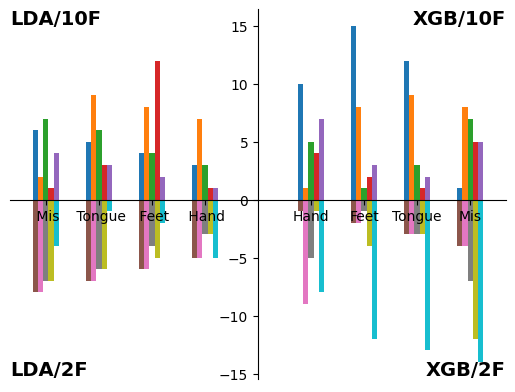

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis', ' Hand', ' Feet', ' Tongue', ' Mis']
labels_to_x = {'Hand':1, 'Feet':2, 'Tongue':3, 'Mis':4, ' Hand':-1, ' Feet':-2, ' Tongue':-3, ' Mis':-4}

# Convert categories to numerical x-values
x = [labels_to_x[label] for label in labels]
x = np.array(x)

# Values for different groups
blk1_values_10F = [10, 15, 12, 1, 3, 4, 5, 6]
blk12_values_10F = [1, 8, 9, 8, 7, 8, 9, 2]
blk123_values_10F = [5, 1, 3, 7, 3, 4, 6, 7]
blk1234_values_10F = [4, 2, 1, 5, 1, 12, 3, 1]
blk12345_values_10F = [7, 3, 2, 5, 1, 2, 3, 4]

blk1_values_2F = [1, 2, 3, 4, 5, 6, 7, 8]
blk12_values_2F = [9, 2, 3, 4, 5, 6, 7, 8]
blk123_values_2F = [5, 1, 3, 7, 3, 4, 6, 7]
blk1234_values_2F = [1, 4, 3, 12, 3, 5, 6, 7]
blk12345_values_2F = [8, 12, 13, 14, 5, 2, 1, 4]

# Set the width of the bars within each group
bar_width = 0.1

# Create a figure and axis
fig, ax = plt.subplots()

# Create the bar charts for all five groups side by side using ax.bar
ax.bar(x - 2*bar_width, blk1_values_10F, width=bar_width, label='blk1 10F')
ax.bar(x - bar_width, blk12_values_10F, width=bar_width, label='blk2 10F')
ax.bar(x, blk123_values_10F, width=bar_width, label='blk3 10F')
ax.bar(x + bar_width, blk1234_values_10F, width=bar_width, label='blk4 10F')
ax.bar(x + 2*bar_width, blk12345_values_10F, width=bar_width, label='blk5 10F')

ax.bar(x - 2*bar_width, [-i for i in blk1_values_2F], width=bar_width, label='blk1 2F')
ax.bar(x - bar_width, [-i for i in blk12_values_2F], width=bar_width, label='blk2 2F')
ax.bar(x, [-i for i in blk123_values_2F], width=bar_width, label='blk3 2F')
ax.bar(x + bar_width, [-i for i in blk1234_values_2F], width=bar_width, label='blk4 2F')
ax.bar(x + 2*bar_width, [-i for i in blk12345_values_2F], width=bar_width, label='blk5 2F')

# Axis adjustments
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xticks(x)
ax.set_xticklabels(labels)


# Adding custom section titles
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Top left (B)
ax.text(xlims[0], ylims[1], 'LDA/10F', horizontalalignment='left', verticalalignment='top', fontsize=14, weight='bold')

# Top right (A)
ax.text(xlims[1], ylims[1], 'XGB/10F', horizontalalignment='right', verticalalignment='top', fontsize=14, weight='bold')

# Bottom left (C)
ax.text(xlims[0], ylims[0], 'LDA/2F', horizontalalignment='left', verticalalignment='bottom', fontsize=14, weight='bold')

# Bottom right (D)
ax.text(xlims[1], ylims[0], 'XGB/2F', horizontalalignment='right', verticalalignment='bottom', fontsize=14, weight='bold')

# Show the plot
plt.show()


[0.6262996941896024, 0.5989296636085627, 0.5556574923547402, 0.5542813455657492, 0.6674311926605505, 0.6262996941896024, 0.5636085626911315, 0.5909785932721713]
[0.6955963302752294, 0.6959633027522936, 0.6185321100917431, 0.6258715596330275, 0.7253211009174312, 0.7231192660550458, 0.6411009174311927, 0.6555963302752295]
[0.730045871559633, 0.7243119266055046, 0.6844036697247706, 0.6701834862385321, 0.7834862385321101, 0.7566513761467891, 0.7077981651376146, 0.6871559633027522]
[0.7758409785932722, 0.7519877675840979, 0.7128440366972477, 0.737920489296636, 0.7972477064220185, 0.7483180428134556, 0.7214067278287462, 0.7409785932721713]
[0.7908256880733946, 0.7706422018348624, 0.7224770642201837, 0.7192660550458715, 0.8105504587155963, 0.7706422018348623, 0.7440366972477065, 0.7233944954128442]
[0.5986238532110092, 0.5772171253822631, 0.5370030581039755, 0.5344036697247707, 0.6640672782874618, 0.602446483180428, 0.568960244648318, 0.5533639143730886]
[0.6739449541284404, 0.664587155963302

/tmp/ipykernel_26464/3915897302.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=40)  # Adjust the fontsize as needed


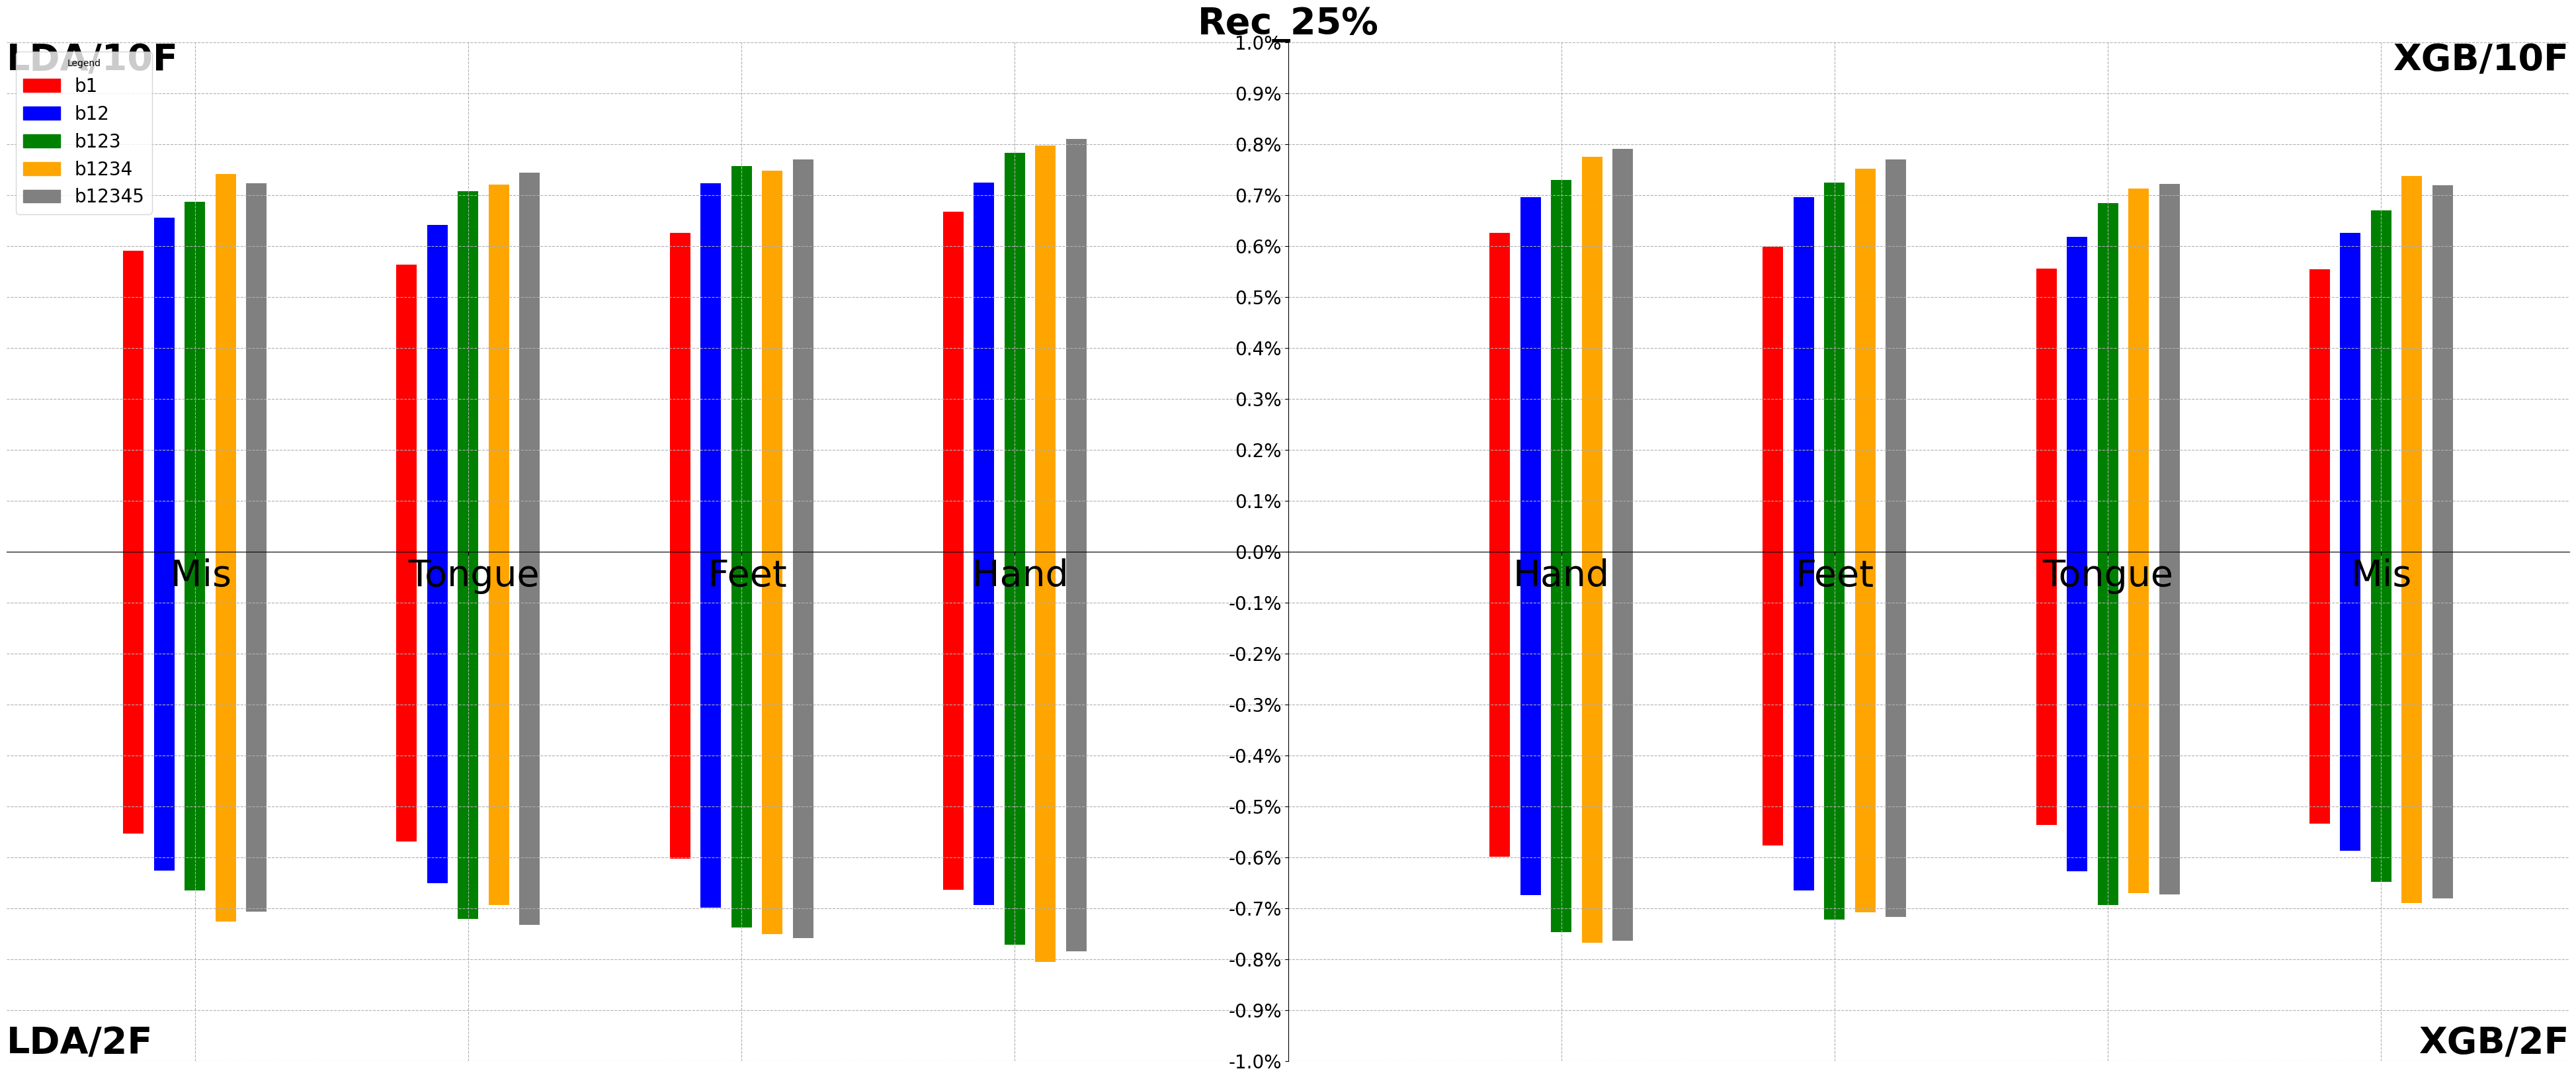

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis', ' Hand', ' Feet', ' Tongue', ' Mis']
labels_to_x = {'Hand':1, 'Feet':2, 'Tongue':3, 'Mis':4, ' Hand':-1, ' Feet':-2, ' Tongue':-3, ' Mis':-4}




x = [labels_to_x[label]*4 for label in labels]
x = np.array(x)



PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
classifier_name = "XGB"
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 25
window_time_length = 4
window_type = "Rec"

train_blk_set_dic = {"1":"red","12":"blue","123":"green","1234":"orange","12345":"grey"}
n = len(train_blk_list)
m = list(range(-(n-1)//2, (n-1)//2 + 1))
# train_blk_list = ["12345","1234","123","12","1"]
number_of_selected_features_list = [10,2]
bar_width = 0.3
fig, ax = plt.subplots(figsize=(50, 20))

legend_labels = ['b1', 'b12', 'b123', 'b1234', 'b12345']
colors = train_blk_set_dic.values()
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
for number_of_selected_features in number_of_selected_features_list:
    for index, (train_blk, color) in enumerate(zip(train_blk_set_dic.keys(), train_blk_set_dic.values())):
        classifier_name = "XGB"
        acc_list_1 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        classifier_name = "LDA"
        acc_list_2 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        blk_values = acc_list_1 + acc_list_2
        print(blk_values)
        if number_of_selected_features == 2:
            blk_values = [-j for j in blk_values]
            
        ax.bar(x + m[index]*bar_width*1.5, blk_values, width=bar_width, color=color)



ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=40)
ax.set_yticklabels(ax.get_yticks(), fontsize=40)  # Adjust the fontsize as needed

y_max = max(ax.get_yticks())
y_ticks = [i*10/100  for i in range(-10,11)]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{float(val)}%' for val in y_ticks], fontsize=20)
ax.grid(True, linestyle='--')

# y_ticks = ax.get_yticks()
# y_max = max(y_ticks)
# for i in range(1, 10):
#     y_value = i / 10 * y_max
#     ax.axhline(y=y_value, color='gray', linestyle='--')
ax.legend(legend_patches, legend_labels, fontsize=20, title='Legend')
ax.set_title(f'{window_type}_{overlap_percent}%', fontsize=40, weight='bold')






xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Top left (B)
ax.text(xlims[0], ylims[1], 'LDA/10F', horizontalalignment='left', verticalalignment='top', fontsize=40, weight='bold')

# Top right (A)
ax.text(xlims[1], ylims[1], 'XGB/10F', horizontalalignment='right', verticalalignment='top', fontsize=40, weight='bold')

# Bottom left (C)
ax.text(xlims[0], ylims[0], 'LDA/2F', horizontalalignment='left', verticalalignment='bottom', fontsize=40, weight='bold')

# Bottom right (D)
ax.text(xlims[1], ylims[0], 'XGB/2F', horizontalalignment='right', verticalalignment='bottom', fontsize=40, weight='bold')

# Show the plot
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/{window_type}_{overlap_percent}%.svg', dpi=300, bbox_inches='tight')
plt.show()



In [43]:
def return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk_set):

    path = os.path.join(
    PATH,
    classifier_name,
    f"{number_of_components}_CSP_Components",
    f"{number_of_selected_features}-Selected_Features",
    f"{overlap_percent}%_Overlap",
    f"{window_time_length}_window_time_length",
    f"{window_type}_Window",
    f"{train_blk_set}_Train/"
    )

    data_dic = {path:pd.read_csv(path+"AverageAcc.csv")}
    acc = list(data_dic[path]['test_acc'])
    return acc


In [73]:
n =7
m = list(range(-(n-1)//2, (n-1)//2 + 1))
print(m)

[-3, -2, -1, 0, 1, 2, 3]


# Side Analysis

In [38]:
# #Frame Maker
PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v4/XGB/"
df = pd.read_csv(PATH+'frame.csv')
p_num_list = [3,4,5,6,7,9,10,11,13,14,15]
for p_num in p_num_list:
    df.to_csv(PATH+'P'+str(p_num)+'.csv',index=False)



In [ ]:
path = os.path.join(
    PATH,
    classifier_name,
    f"{number_of_components}_CSP_Components",
    f"{number_of_selected_features}-Selected_Features",
    overlapflag,
    f"{window_time_length}_window_time_length",
    f"{window_type}_Window",
    f"{train_blk_name}_Train/",
)
print(path + f"P{p_num}.csv")

In [ ]:
import pandas as pd

def save_csv(new_row, classifier, number_of_components, number_of_selected_features, overlapflag,
             window_time_length, window_type, train_blk_name, p_num):
    # Convert to relative path
    relative_path = os.path.join(
        classifier,
        f"{number_of_components}_CSP_Components",
        f"{number_of_selected_features}-Selected_Features",
        overlapflag,
        f"{window_time_length}_window_time_length",
        window_type,
        f"{train_blk_name}_Train",
        f"P{p_num}.csv"
    )

    # Convert relative path to absolute path
    absolute_path = os.path.abspath(relative_path)

    # Read existing CSV or create an empty DataFrame
    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    # Create a new row DataFrame
    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)

    # Concatenate existing DataFrame and new row DataFrame
    cf = pd.concat([rf, new_row_df], ignore_index=True)

    # Write the concatenated DataFrame to CSV
    cf.to_csv(absolute_path, index=False)

# Example usage
classifier = "XGBClassifier"
number_of_components = 10
number_of_selected_features = 10
overlapflag = "With_Overlap"
window_time_length = "4_window_time_length"
window_type = "50% Overlap"
train_blk_name = "12345"
p_num = 9

new_row = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10]
save_csv(new_row, classifier, number_of_components, number_of_selected_features, overlapflag,
         window_time_length, window_type, train_blk_name, p_num)


In [ ]:

# # Specific path and file name
# file_path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/frame.csv'  # Replace with your specific path
# df = pd.DataFrame(columns=column_names)
# # Write the DataFrame to a CSV file at the specified path
# df.to_csv(file_path, index=False)

In [ ]:
first_list = ["12345", "1234", "123", "12", "1"]

second_list = []

for item in first_list:
    result = ""
    for i in range(len(item) - 1):
        result += str(int(item[i]) + int(item[i + 1]))
    second_list.append(result)

print(second_list)


In [ ]:
train_blk_set_dic = {"01234":[0,1,2,3,4],"0123":[0,1,2,3],"012":[0,1,2],"01":[0,1],"0":[0]}
for train_blk_set,train_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys()):
    print(len(train_blk_set))
    print(train_blk_name)

In [ ]:
def remove_outliers(df):
    # Specify the threshold for outliers (you can adjust this based on your data)
    threshold = 10 ** 5

    # Calculate median and MAD for each row
    median = df.iloc[:, :-1].median(axis=1)
    mad = np.median(np.abs(df.iloc[:, :-1].sub(median, axis=0)), axis=1)
    threshold_array = median + threshold * mad

    # Identify rows with values exceeding the threshold
    outliers = df.iloc[:, :-1].gt(threshold_array[:, None], axis=0).any(axis=1)

    # Remove rows identified as outliers
    clean_df = df[~outliers]

    return clean_df


In [35]:

#Pikle_converter
def data_reader(path,p_num,block_list):
    data_dict = {}
    for b_num in block_list:
        print(b_num)
        mat = loadmat(path+'P'+ str(p_num) + '/'+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
        df = pd.DataFrame(mat['Data'])
        df.to_pickle(f"{path}Pickels_Participants/P{p_num}/P{p_num}B{b_num}.pkl")
    #     data_dict[b_num] = df
    # return data_dict

In [36]:
block_list = [0,1,2,3,4,5,6]
p_num_list = [15]
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/'
for p_num in p_num_list:
    print("reading",p_num)
    data_reader(path,p_num,block_list)



reading 15
0
1
2
3
4
5
6


In [41]:
print(len()data_dict_list)

SyntaxError: invalid syntax (3878301127.py, line 1)

In [ ]:
from scipy import stats

def remove_outliers_across_channels(df, threshold):
    # print(df.shape,"shape0")

    data_columns = df.columns[:-1]  # Excluding the label column by default

    # Separate the label column
    labels = df.iloc[:, -1]  # Assuming the label is in the last column
    data_without_label = df.iloc[:, :-1]  # DataFrame without the label column

    # Calculate Z-scores for each row
    # print(data_without_label.shape,"shape1")
    # print(data_without_label[data_columns].shape,"shape2")
    # print(data_without_label.head(10))
    data_without_label[data_columns] = data_without_label[data_columns].apply(pd.to_numeric, errors='coerce')
    z_scores = stats.zscore(data_without_label[data_columns], axis=1)
    abs_z_scores = abs(z_scores)

    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    filtered_data = data_without_label[filtered_entries]

    # Remove corresponding labels for removed rows
    filtered_labels = labels[filtered_entries]

    # If you want to reset index after filtering
    filtered_data.reset_index(drop=True, inplace=True)
    filtered_labels.reset_index(drop=True, inplace=True)

    # Combine the filtered data and labels
    filtered_df = pd.concat([filtered_data, filtered_labels], axis=1)

    return filtered_df


In [ ]:
prediction_list = [1, 1, 1, 1, 0, 0, 1, 1, 0, 0]  # Replace with your actual prediction list

result = majority_vote_sliding_with_next(prediction_list)
result2 = majority_vote_sliding_with_prev_v2(prediction_list)
print("Majority Votes:", result)
print("Majority Votes Previous:", result2)

## Getting Average

In [ ]:
PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/Win4Shift2/'
p_num_list = [3,4,5,6,7,9,10,11,13,14]
vf = pd.DataFrame(columns=column_names_v2) 
for p_num in p_num_list:
    print(p_num)
    rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
    vf = pd.concat([vf, rf], ignore_index=True)
vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)
# vf.tail()
    
columnNames = ['class','test_acc','vote_acc']
kf = pd.DataFrame(columns=columnNames)
kf.to_csv(PATH+'AverageAcc.csv',index=False)

vf = pd.read_csv(PATH +"ResultsOfAll.csv")
df = vf

class_list=['Hand','Feet','Tongue','Mis']
blk_list = [1234]
for class_ in class_list:
    avg_list = []
    avg_vote_list = []
    for blk in blk_list:
        gf = df[(df['train_block'] == blk) & (df['class1'] == class_)]
        avg = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean()
        avg_list.append(avg)
        avg_vote_list.append(avg_vote)
    print(avg_list)    
    new_row = [class_, avg_list[0],avg_vote_list[0]] 
    new_row_df = pd.DataFrame([new_row], columns=columnNames)
    rf = pd.read_csv(PATH + 'AverageAccExcP8.csv')
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(PATH +'AverageAccExcP8.csv',index=False)  
kf = pd.read_csv(PATH +'AverageAccExcP8.csv') 
kf.head()

In [ ]:
# Assuming df is your DataFrame with the last column named 'label'
data = {'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter'],
        'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b']}

df = pd.DataFrame(data)

print(df)
print("his")
# Define a custom sorting order based on the desired grouping
sorting_order = {'a': 0, 'b': 1}

# Create a new column with the sorting order
df['sorting_order'] = df.iloc[:, 2].map(sorting_order)

# Sort the DataFrame based on the new column and the original order within each group
df.sort_values(by=['sorting_order', df.columns[2]], inplace=True)

# Drop the temporary sorting column
df.drop('sorting_order', axis=1, inplace=True)

# Optional: Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(df)





In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter','b'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b','b']
}

df = pd.DataFrame(data)

x=0
i=0
class_1 = 'a'
class_2 = 'b'
sampleList = []
while i<len(df):
    if (df.iloc[i,2]==class_1):
        x+=1
    else:
        i-=1
        sampleList.append(x)
        x=0
        class_1,class_2 = class_2,class_1
    i+=1
sampleList.append(x)
print(sampleList)

In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'it', 'does', 'not matter'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'b', 'b', 'b']
}
df = pd.DataFrame(data)

print(get_group_start_indices(df))


In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter','c'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b','b']
}

df = pd.DataFrame(data)

# Identify consecutive groups of 'a's by creating a new group ID each time 'label' changes from 'b' to 'a'
df['group'] = (df['label'] != df['label'].shift(1)).cumsum()

# Count occurrences of 'a' within each group
group_counts = df[df['label'] == 'a'].groupby('group').size()

group_counts_b = df[df['label'] == 'b'].groupby('group').size()
print(group_counts_b)
print(group_counts_b.index[0])
print(group_counts_b.iloc[0])
print(group_counts)

In [ ]:
p_num = 8
b_num = 7
path = f'../../Participants/P{p_num}v5/'
mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
df = pd.DataFrame(mat['Data'])

path = f'../../Participants/P{p_num}v0/'
mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
df_1 = pd.DataFrame(mat['Data'])

print(df.shape)
print(df_1.shape)


In [ ]:
from skimage.filters import median

def apply_median_filter(df, window_size=10):
    channel_data = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values 
    filtered_channel_data = np.zeros_like(channel_data) 

    for i in range(channel_data.shape[1]):
        print(i,"channel")
        filtered_channel_data[:, i] = median(channel_data[:, i], selem=np.ones(window_size))

    df_filtered = pd.DataFrame(filtered_channel_data, columns=df.columns[:-1])
    df_filtered['Label'] = labels
    print(df_filtered.shape, "shape after median filter")

    return df_filtered


In [ ]:
def apply_pca(train_data, test_data=None, n_components=50):
    # Reshape train data
    train_data_reshaped = np.reshape(train_data, (train_data.shape[0], -1))


    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data_reshaped)
    # scaled_train_data = train_data_reshaped
    
    # Apply PCA on train data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_train_data)
    transformed_train_data = pca.transform(scaled_train_data)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)
    print("\nCumulative Explained Variance:")
    print(cumulative_explained_variance)


    test_data_reshaped = np.reshape(test_data, (test_data.shape[0], -1))
    scaled_test_data = scaler.transform(test_data_reshaped)
    transformed_test_data = pca.transform(scaled_test_data)

    return transformed_train_data, transformed_test_data


In [ ]:
extra_samples_block_counter(df_1,trial_order[0])

In [ ]:
for b in range(7):
    extra_samples_block_counter(data_dicts_list[-1][b],trial_order[b],b)